# RLHF Fine-Tuning for Degradation Transformer

This notebook demonstrates how to fine-tune the pre-trained Degradation Transformer using Reinforcement Learning (REINFORCE) to improve long-term trajectory prediction.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
from torch.utils.data import DataLoader

## 1. Load Pre-trained Model
We load the model weights and configuration from the saved files.

In [2]:
import json
from safetensors.torch import load_model

# Load Config
with open('degradation_transformer_model_config.json', 'r') as f:
    config = json.load(f)

# Initialize Model Structure
model = DegradationTransformer(
    vocab_size=config['vocab_size'],
    context_window=config['context_window'],
    embedding_dim=config['embedding_dim'],
    num_heads=config['num_heads'],
    num_blocks=config['num_blocks']
)

# Load Weights
load_model(model, 'degradation_transformer_model.safetensors')
print("Model loaded successfully!")

Model loaded successfully!


## 2. Generate Data for RLHF
We generate a fresh batch of degradation episodes. We need long episodes to have enough future steps for the reward calculation.

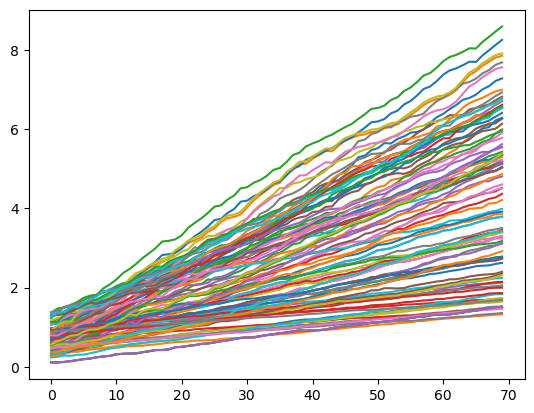

In [3]:
# Parameters
CONTEXT_WINDOW = config['context_window']
FUTURE_WINDOW = 20  # Length of trajectory to predict and reward
EPISODE_LENGTH = CONTEXT_WINDOW + FUTURE_WINDOW + 10 # Extra buffer
NUM_EPISODES = 10

# Generate Data (Paris Law)
lin_episodes = np.empty((0, EPISODE_LENGTH))
for c in np.linspace(0.01, 0.1, 50):
    
    lin = LinearDegradation(length=EPISODE_LENGTH, dim=1, c=c, mu_e=0, sigma_e=c/2)
    episodes_i = lin.generate_episode(x0=np.abs(np.random.randn(NUM_EPISODES)*0.3+0.7))  # Initial crack lengths in meters
    lin_episodes = np.concatenate([lin_episodes, episodes_i], axis=0)

#drop invalid values
lin_episodes = lin_episodes[~np.isnan(lin_episodes).any(axis=1)]
lin_episodes = lin_episodes[(lin_episodes<15).all(axis=1)]
lin_episodes = lin_episodes[(lin_episodes>=0).all(axis=1)]

# plot 20 random episodes
plt.plot(lin_episodes[np.random.randint(0, lin_episodes.shape[0], size=100)].T)
lin_episodes.min(), lin_episodes.max(), lin_episodes.shape


data = lin_episodes

#

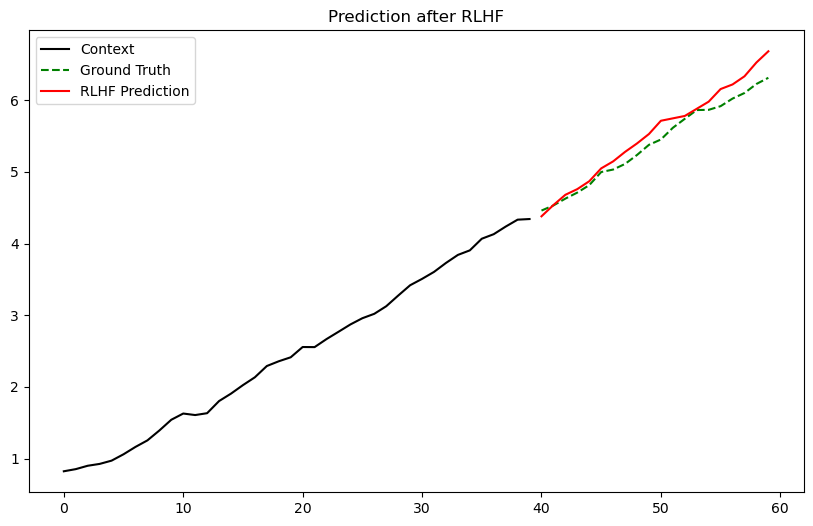

In [13]:
learner1 = Learner(model, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])
# Pick a random test sample
test_idx = np.random.randint(0, lin_episodes.shape[0], size=1)
x_context = data[test_idx, :CONTEXT_WINDOW]
y_true = data[test_idx, CONTEXT_WINDOW:CONTEXT_WINDOW+FUTURE_WINDOW]

# Predict
y_pred,log_probs = learner1.predict(x_context, num_periods=FUTURE_WINDOW, temperature=0.0) # Greedy for eval

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(CONTEXT_WINDOW), x_context.T, 'k-', label='Context')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_true.T, 'g--', label='Ground Truth')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_pred.T, 'r-', label='RLHF Prediction')
plt.legend()
plt.title("Prediction after RLHF")
plt.show()


## 3. Prepare RL Dataset and Learner
We use the new `RLDataset` and `RLHFLearner`.

In [5]:
# Create Dataset
rl_dataset = RLDataset(data, CONTEXT_WINDOW, FUTURE_WINDOW, config['vocab_size'])
train_loader = DataLoader(rl_dataset, batch_size=32, shuffle=True)

# Initialize Learner
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) # Low learning rate for fine-tuning
reward_func = MSE_Reward()

learner = RLHFLearner(
    model=model,
    optim=optimizer,
    reward_func=reward_func,
    train_loader=train_loader,
    cbs=[], # Add callbacks if needed
    device='mps' # or 'cuda'/'mps'
)

In [6]:
rn = next(iter(train_loader))
rn[0].shape, rn[1].shape, rn[2].shape, rn[3].shape

(torch.Size([32, 40]),
 torch.Size([32, 20]),
 torch.Size([32, 2, 1]),
 torch.Size([32, 40]))

In [7]:
len(rl_dataset), len(train_loader)

(5000, 157)

## 4. Run RLHF Training
We run the `fit_rl` method. We use a temperature > 0 to encourage exploration during training.

In [9]:
print("Starting RLHF Fine-tuning...")
learner.fit_rl(
    num_epochs=2,
    future_window=FUTURE_WINDOW,
    temperature=1.0, # Exploration
    baseline_momentum=0.9
)

Starting RLHF Fine-tuning...


/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:903: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32, device=self.device) # (batch, future_window)


Epoch 0, Batch 0, Avg Reward: -0.1207, Loss: -3.2378
Epoch 0, Batch 10, Avg Reward: -0.1104, Loss: -0.1799
Epoch 0, Batch 20, Avg Reward: -0.0929, Loss: -0.2354
Epoch 0, Batch 30, Avg Reward: -0.1181, Loss: -0.1135
Epoch 0, Batch 40, Avg Reward: -0.1881, Loss: -8.0534
Epoch 0, Batch 50, Avg Reward: -0.0951, Loss: -0.8465
Epoch 0, Batch 60, Avg Reward: -0.0842, Loss: 1.7572
Epoch 0, Batch 70, Avg Reward: -0.1623, Loss: -4.6049
Epoch 0, Batch 80, Avg Reward: -0.1692, Loss: -4.0163
Epoch 0, Batch 90, Avg Reward: -0.0687, Loss: 3.0523
Epoch 0, Batch 100, Avg Reward: -0.1170, Loss: -1.6828
Epoch 0, Batch 110, Avg Reward: -0.1151, Loss: 0.9704
Epoch 0, Batch 120, Avg Reward: -0.0783, Loss: 2.7776
Epoch 0, Batch 130, Avg Reward: -0.1327, Loss: -3.0663
Epoch 0, Batch 140, Avg Reward: -0.1123, Loss: -0.1383
Epoch 0, Batch 150, Avg Reward: -0.0606, Loss: 3.8879
Epoch 0 Finished. Mean Reward: -0.1243
Epoch 1, Batch 0, Avg Reward: -0.0568, Loss: 2.3428
Epoch 1, Batch 10, Avg Reward: -0.1018, Loss:

## 5. Evaluate Results
Let's compare the model's predictions after fine-tuning.

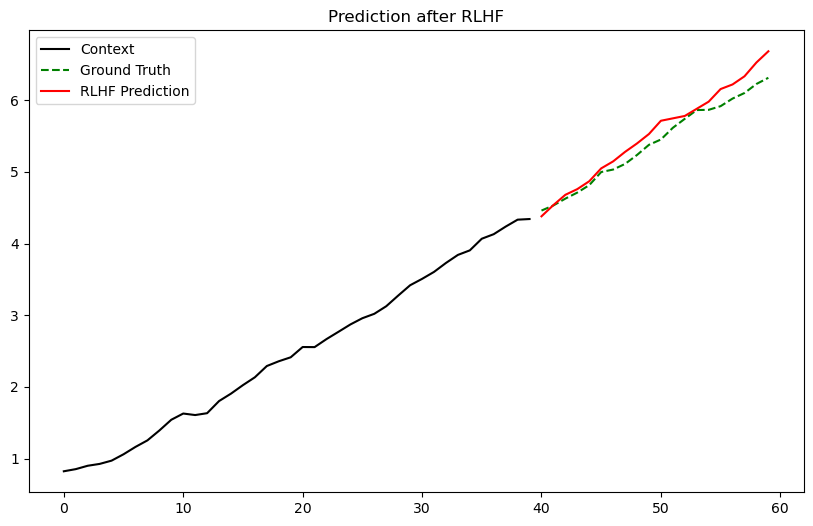

In [14]:
# Pick a random test sample
x_context = data[test_idx, :CONTEXT_WINDOW]
y_true = data[test_idx, CONTEXT_WINDOW:CONTEXT_WINDOW+FUTURE_WINDOW]

# Predict
y_pred,_ = learner.predict(x_context, num_periods=FUTURE_WINDOW, temperature=0.0) # Greedy for eval

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(CONTEXT_WINDOW), x_context.T, 'k-', label='Context')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_true.T, 'g--', label='Ground Truth')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_pred.T, 'r-', label='RLHF Prediction')
plt.legend()
plt.title("Prediction after RLHF")
plt.show()